# Example for ALCHEMIC to probe a parameter range

This is a model for Bisbas et al. (2017) paper to test how the grain surface chemistry effects the [CO]/[H2] and [C]/[H2] ratios with increasing cosmic ray ionisation rates.

The conclusion of the paper is that C abundance is more stable over a large parameter range of densities and cosmic ray rates comapred to CO, thus it may be a better tracer. There are caviats of this result, namely the interstellar UV field does not scale with the cosmic ray rate and that the dynamics of the gas is not modeled. 
Here we find similar trends, even when grains are included. Differences are notably,

 - at high density and intermediate cosmic ray rates, the cosmic rays help to keep the gas phase CO abundance high (due to thermal and desorption effects)
 - 

Regardless of these, this example should show how to set up a parameter study and read and analyse the results.

In [2]:
# Define the HOME folder of the ALCHEMIC code and add it to the PYTHONPATH
home = "/home/laszlo/Work/alchemic-dev/source/alchemic"  # You have to update this to the ALCHEMIC locations!
#home = "/Users/laszlo/Work/alchemic/alchemic/"
import sys
sys.path.append(home+'/_python')
import pychemic as ntw
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

# a function for printing figure to file, this is a copy from a function with the same 
# name from al_commons.py
def saveFig(path, ext='png', close=True, verbose=True):
    """Save a figure from pyplot to a specified file format.

    :param path: The path (and filename, without extension) to save the figure to.
    :type path: string
    :param ext: The file extension (default='png'). This must be supported by
                the active matplotlib backend (see matplotlib.backends module).
                Most backends support 'png', 'pdf', 'ps', 'eps', and 'svg'.
    :type ext: string
    :param close: Whether to close the figure after saving (default=True).
                  If you want to save the figure multiple times (e.g., to
                  multiple formats), you should NOT close it in between
                  saves or you will have to re-plot it.
    :type close: boolean
    :param verbose: Whether to print information about when and where the image
                    has been saved (default=True).
    :type verbose : boolean
    """

    # Extract the directory and filename from the given path
    directory = os.path.split(path)[0]
    filename = "%s.%s" % (os.path.split(path)[1], ext)
    if directory == '':
        directory = '.'

    # If the directory does not exist, create it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # The final path to save to
    savepath = os.path.join(directory, filename)

    if verbose:
        print("Saving figure to '%s'..." % savepath),

    # Actually save the figure
    plt.savefig(savepath,bbox_inches='tight')

    # Close it
    if close:
        plt.close()

    if verbose:
        print("Done")
        
def plotFig(data,tarr,tp=1e6,extent=[2,4,-17,-14],time='10^7',
            xlabel='log(n) [cm$^{-3}$]',ylabel='log($\zeta_{CR}$) [s$^{-1}$]',
            xbin=4,ybin=3,label='log(fractional abundance)',spec='[CO]'):
    nx = len(data[:,0,0])
    ny = len(data[0,:,0])
    toPlot = np.zeros([ nx, ny ])
    tParts = ("%e" % tp).split('e')
    time = ('%.1f * 10^{%.0f}' % (float(tParts[0]), float(tParts[1])) )
    for i in range(nx):
        for j in range(ny):
            fSpec = interpolate.interp1d(tarr,data[i,j,:])
            toPlot[i,j] = fSpec(tp)
    
    pCO = plt.imshow(np.log10(toPlot),aspect='equal',interpolation='none',
                     origin='lower',extent=extent)
    plt.annotate(s=spec+'\n$t = '+time+'$ yr',xy=[2.2,-14.6],alpha=1,
                 backgroundcolor='white')
    pCO.axes.xaxis.set_label_text(xlabel)
    pCO.axes.yaxis.set_label_text(ylabel)
    plt.locator_params(axis='y',nbins=xbin)
    plt.locator_params(axis='x',nbins=ybin)
    plt.colorbar(label=label)

## Read the data directly from the binary file
Freeze-out and desorption are included. 

In [29]:
%cd CRPmol/
# Read the binary file:
CRPGr = ntw.read_alchemic('results/CRPGr.bout')

# Extract the data of interest (now the CO, C, C+ and H2 abundances)

[Errno 2] No such file or directory: 'CRPmol/'
/home/laszlo/Work/alchemic-dev/source/alchemic/_test/CRPmol
Reading results/CRPGr.bout...
12  particle in binary file! Creating ChemModl list...


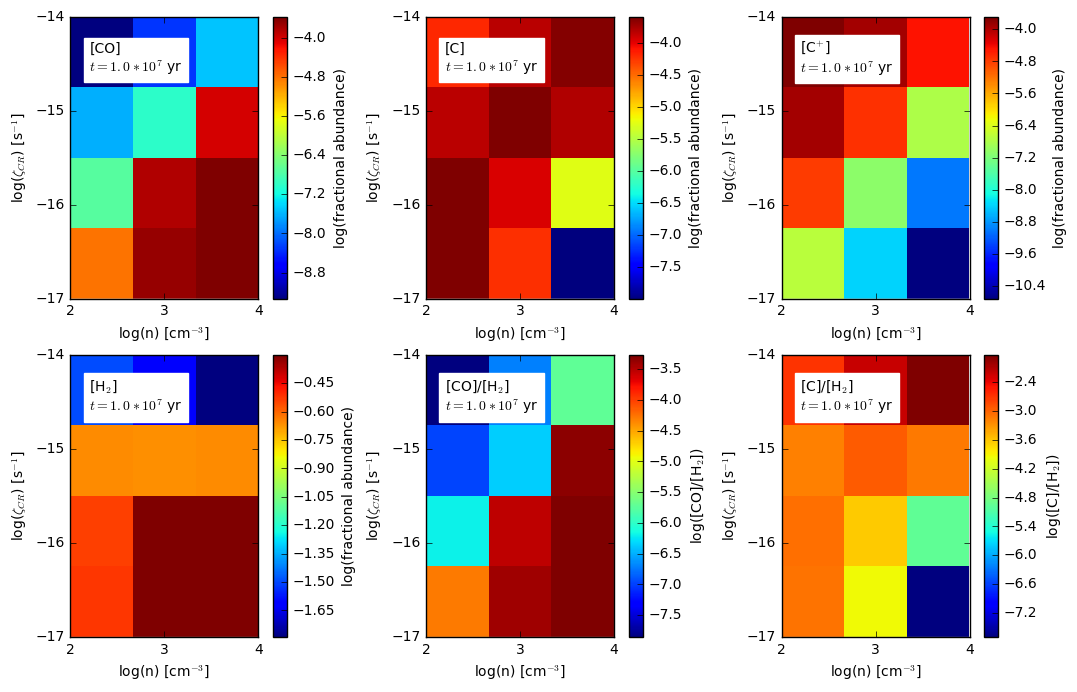

In [30]:
# extract species indexes and number of timesteps
nt = CRPGr[0].nt
t = CRPGr[0].time  # in years
iCO = CRPGr[0].spec.index('CO')
iH2 = CRPGr[0].spec.index('H2')
iC  = CRPGr[0].spec.index('C')
iCp = CRPGr[0].spec.index('C+')

abCO = np.zeros([4,3,nt])
abH2 = np.zeros([4,3,nt])
abC = np.zeros([4,3,nt])
abCp = np.zeros([4,3,nt])

# create the arrays for the axis
rho = np.zeros(3)
CR = np.zeros(4)

j = 0
k = 0
for i in range(len(CRPGr)):
    abCO[k,j,:] = CRPGr[i].abuns[iCO,:] 
    abC[k,j,:]  = CRPGr[i].abuns[iC,:]
    abCp[k,j,:] = CRPGr[i].abuns[iCp,:]
    abH2[k,j,:] = CRPGr[i].abuns[iH2,:]
    rho[j] = CRPGr[i].gdens[0]
    CR[k] = CRPGr[i].ZetaCR[0]
    if k < 3:
        k = k + 1
    elif k == 3:
        k = 0
        j = j+1
#fco = interpolate.interp1d(CRPGr[i].time, CRPGr[i].abuns[iCO,:])
tp = 1e7
# PLot the results:
plt.figure(1,figsize=[13,8])
# panel 1
plt.subplot(231)
plotFig(abCO,t,tp=tp,spec='[CO]')
# panel 2
plt.subplot(232)
plotFig(abC,t,tp=tp,spec='[C]')
# panel 3
plt.subplot(233)
plotFig(abCp,t,tp=tp,spec='[C$^{+}$]')
# panel 4
plt.subplot(234)
plotFig(abH2,t,tp=tp,spec='[H$_{2}$]')
# panel 5
plt.subplot(235)
plotFig(abCO/abH2,t,tp=tp,spec='[CO]/[H$_{2}$]',
        label='log([CO]/[H$_{2}$])')
# panel 6
plt.subplot(236)
plotFig(abC/abH2,t,tp=tp,spec='[C]/[H$_{2}$]',
        label='log([C]/[H$_{2}$])')

plt.show()

# Write to file if needed:
#saveFig('CRP_1e6yr')

[]

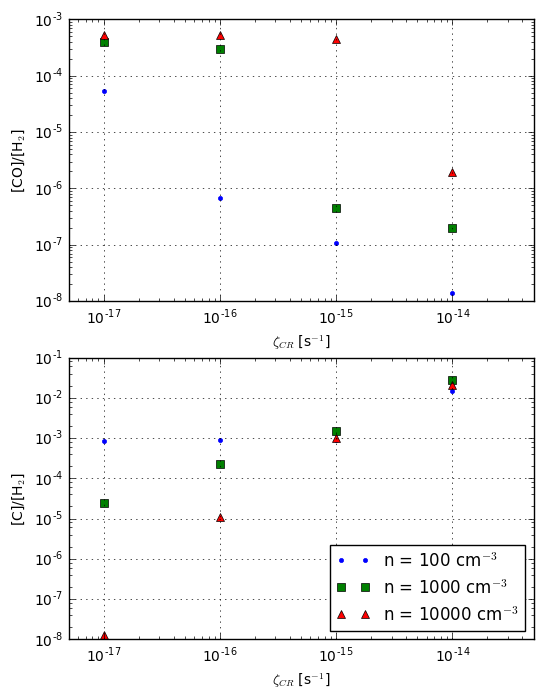

In [44]:
# Plot X-factors
#
plt.figure(1,figsize=[6,8])
plt.subplot(211)

data = abCO/abH2
nx = len(data[:,0,0])
ny = len(data[0,:,0])
toPlot = np.zeros([ nx, ny ])
for i in range(nx):
    for j in range(ny):
        fSpec = interpolate.interp1d(t,data[i,j,:])
        toPlot[i,j] = fSpec(tp)

plt.plot(CR,toPlot[:,0],'.',label='n = 100 cm$^{-3}$')
plt.xlabel('$\zeta_{CR}$ [s$^{-1}$]')
plt.ylabel('[CO]/[H$_2$]')
plt.plot(CR,toPlot[:,1],'s',label='n = 1000 cm$^{-3}$')
plt.plot(CR,toPlot[:,2],'^',label='n = 10000 cm$^{-3}$')
plt.axis([5e-18,5e-14,1e-8,1e-3])
plt.grid(True)
#plt.legend()
plt.loglog()

plt.subplot(212)
plt.plot(CR,(abC/abH2)[:,0,80],'.',label='n = 100 cm$^{-3}$')
plt.plot(CR,(abC/abH2)[:,1,80],'s',label='n = 1000 cm$^{-3}$')
plt.plot(CR,(abC/abH2)[:,2,80],'^',label='n = 10000 cm$^{-3}$')
plt.axis([5e-18,5e-14,1e-8,1e-1])
plt.xlabel('$\zeta_{CR}$ [s$^{-1}$]')
plt.ylabel('[C]/[H$_2$]')
plt.grid(True)
plt.legend(loc=4)
plt.loglog()

#saveFig('Xfactors_1e7yr_mixInit_UVoff_noGrain')

Reading results/CRPGr_00000003.idl...


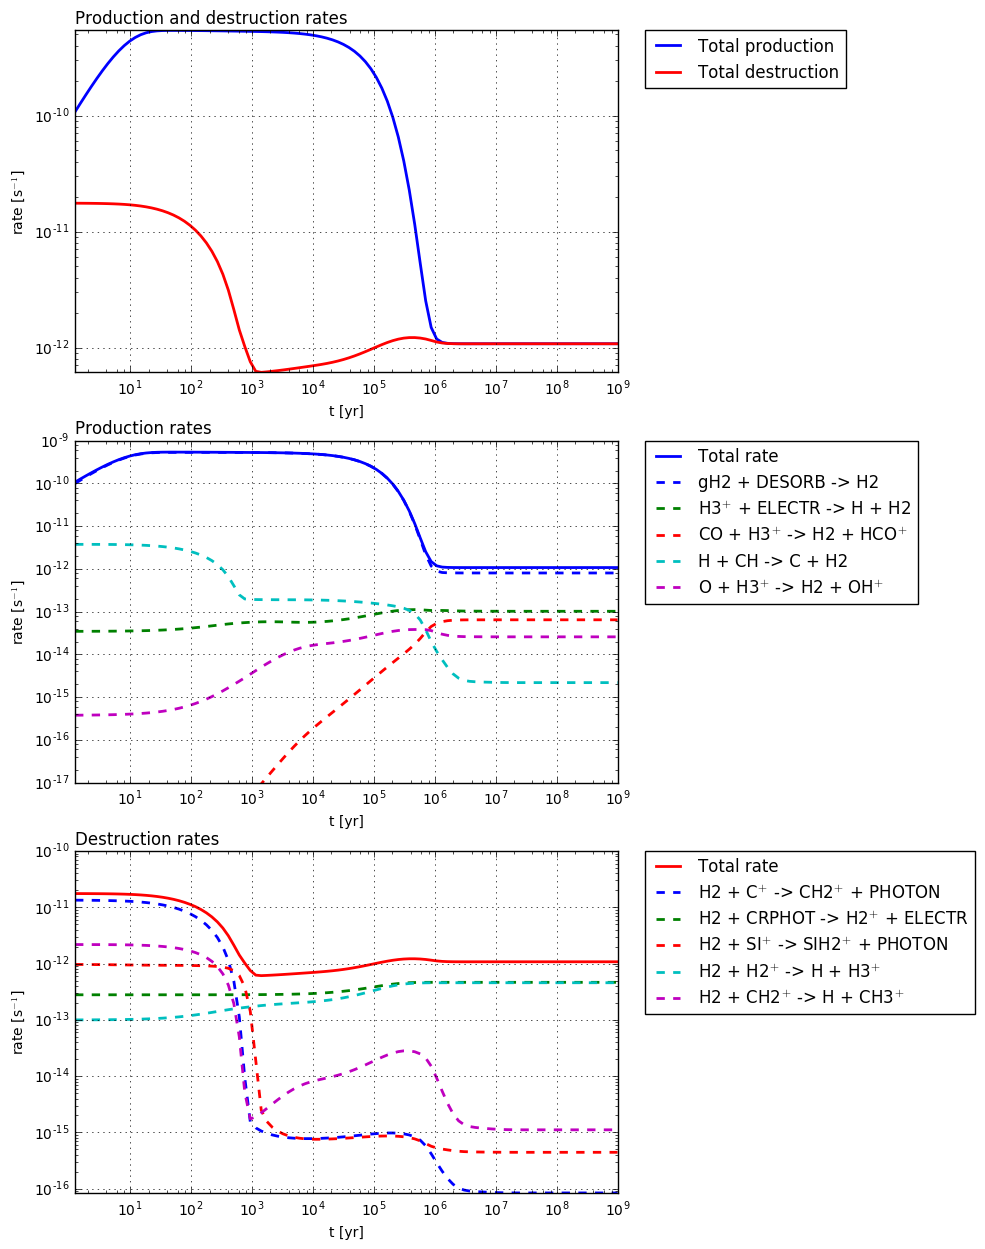

In [43]:
# Analyse the formation and destruction rates:
a = ntw.read_alchemic(filename='results/CRPGr_00000003.idl')
a.PlotRates(species='H2')

In [16]:
# In principle on can make a movie:

for i in range(nt):
    # Plot the results:
    plt.figure(1,figsize=[13,8])
    # panel 1
    plt.subplot(231)
    plotFig(abCO,t,tp=t[i],spec='[CO]')
    # panel 2
    plt.subplot(232)
    plotFig(abC,t,tp=t[i],spec='[C]')
    # panel 3
    plt.subplot(233)
    plotFig(abCp,t,tp=t[i],spec='[C$^{+}$]')
    # panel 4
    plt.subplot(234)
    plotFig(abH2,t,tp=t[i],spec='[H$_{2}$]')
    # panel 5
    plt.subplot(235)
    plotFig(abCO/abH2,t,tp=t[i],spec='[CO]/[H$_{2}$]',
        label='log([CO]/[H$_{2}$])')
    # panel 6
    plt.subplot(236)
    plotFig(abC/abH2,t,tp=t[i],spec='[C]/[H$_{2}$]',
        label='log([C]/[H$_{2}$])')

# Write to file if needed:
    saveFig( ('CRP_%.1eyr ' % t[i]) )

Saving figure to './CRP_1.2e+00yr .png'... Done
Saving figure to './CRP_1.5e+00yr .png'... Done
Saving figure to './CRP_1.9e+00yr .png'... Done
Saving figure to './CRP_2.3e+00yr .png'... Done
Saving figure to './CRP_2.8e+00yr .png'... Done
Saving figure to './CRP_3.5e+00yr .png'... Done
Saving figure to './CRP_4.3e+00yr .png'... Done
Saving figure to './CRP_5.3e+00yr .png'... Done
Saving figure to './CRP_6.5e+00yr .png'... Done
Saving figure to './CRP_7.9e+00yr .png'... Done
Saving figure to './CRP_9.8e+00yr .png'... Done
Saving figure to './CRP_1.2e+01yr .png'... Done
Saving figure to './CRP_1.5e+01yr .png'... Done
Saving figure to './CRP_1.8e+01yr .png'... Done
Saving figure to './CRP_2.2e+01yr .png'... Done
Saving figure to './CRP_2.8e+01yr .png'... Done
Saving figure to './CRP_3.4e+01yr .png'... Done
Saving figure to './CRP_4.2e+01yr .png'... Done
Saving figure to './CRP_5.1e+01yr .png'... Done
Saving figure to './CRP_6.3e+01yr .png'... Done
Saving figure to './CRP_7.8e+01yr .png'.

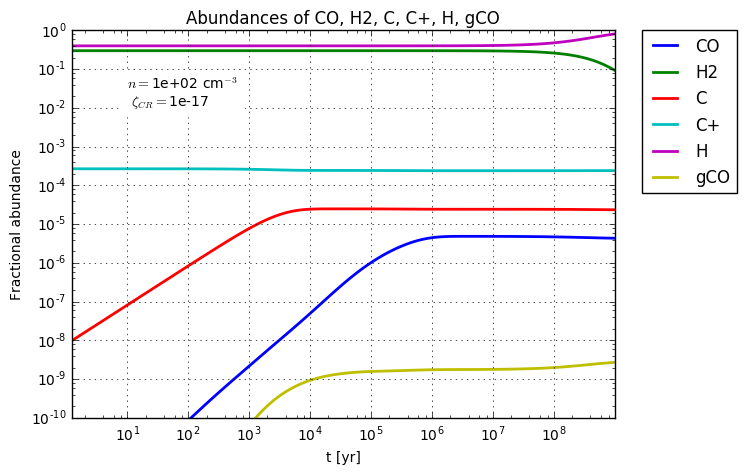

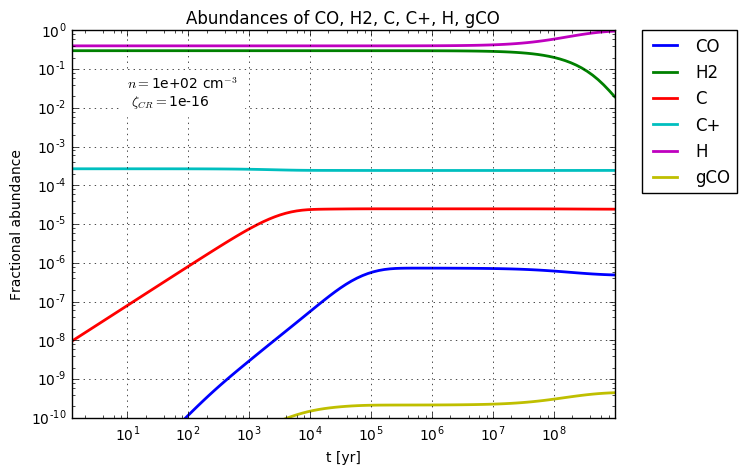

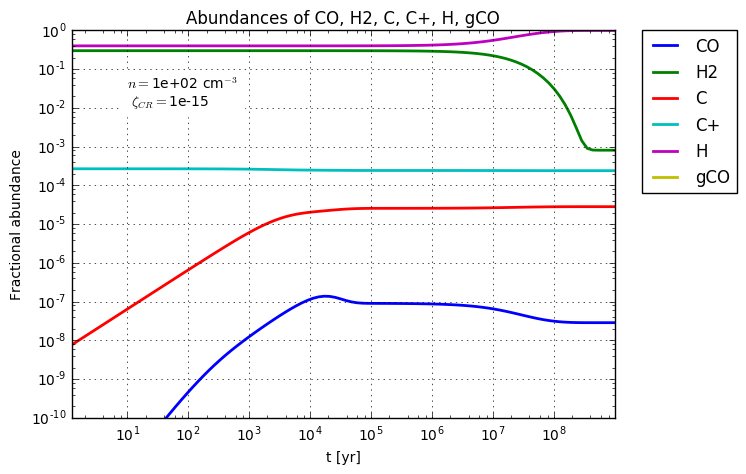

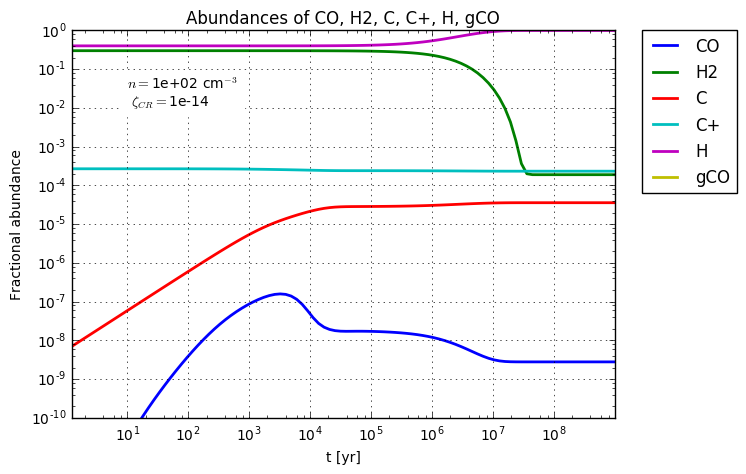

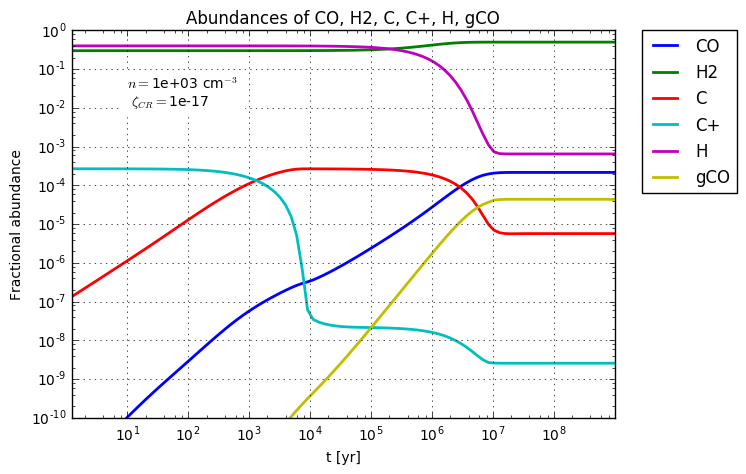

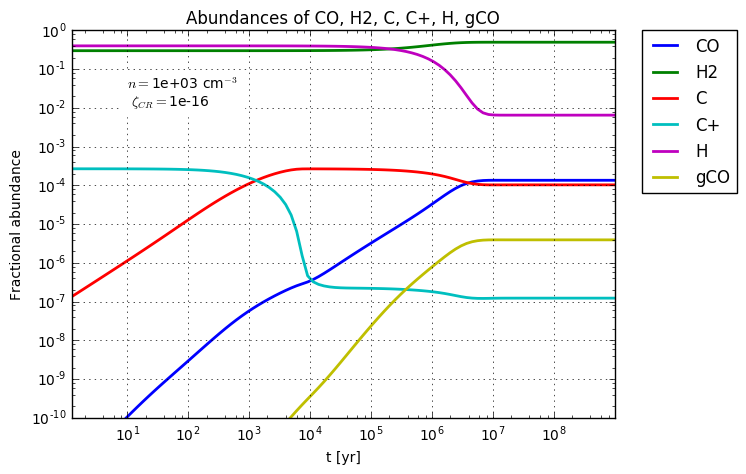

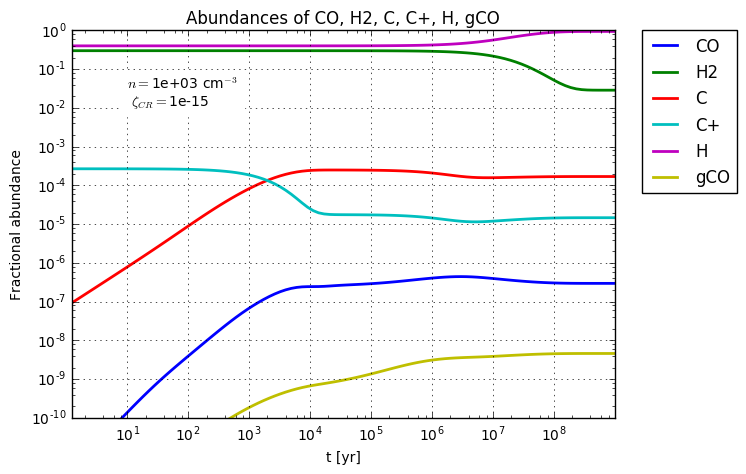

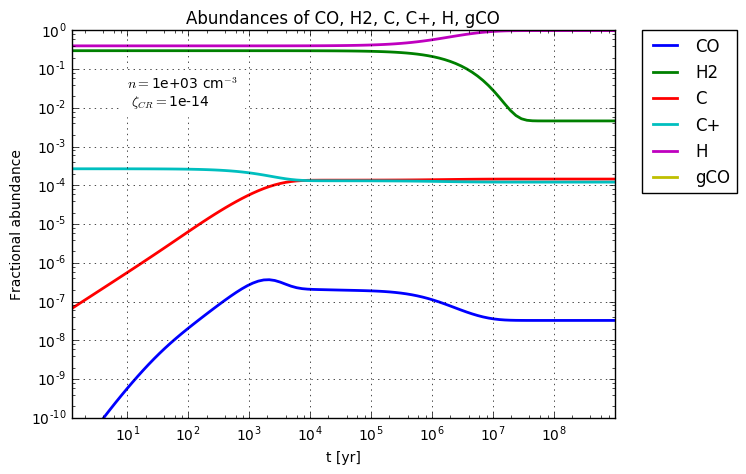

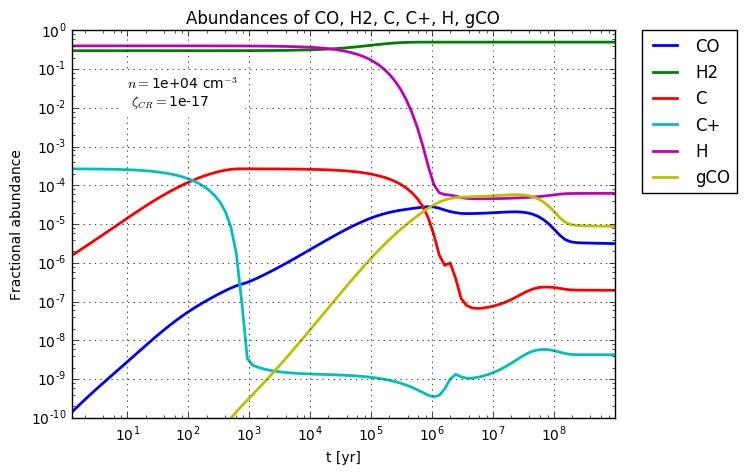

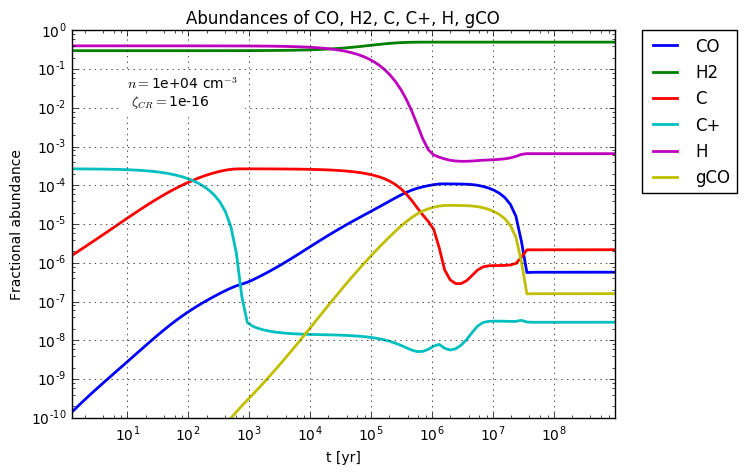

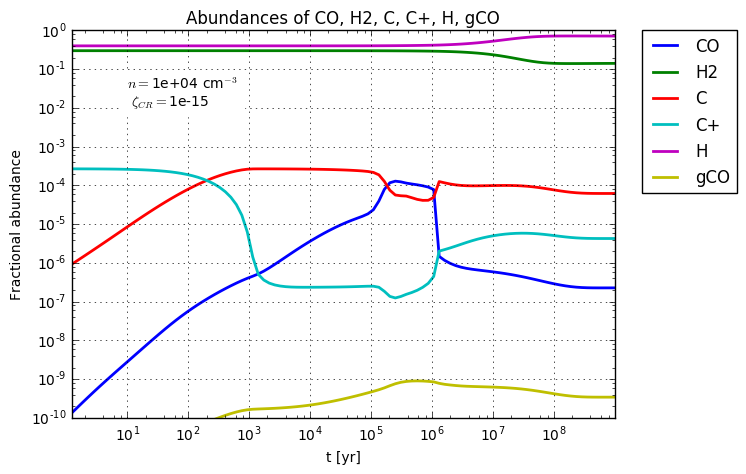

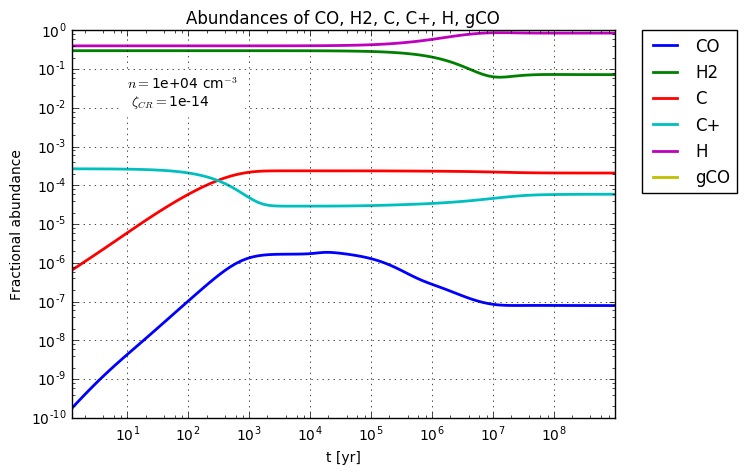

In [15]:
# Plot the actual abundance evolution
for i in range(len(CRPGr)):
    CRPGr[i].PlotAbuns(species=["CO","H2","C","C+","H","gCO"],xlog=True)
    plt.annotate(s=('$n = $%.0e cm$^{-3}$\n $\zeta_{CR} = $%.0e' % (CRPGr[i].gdens[0], 
                                                                    CRPGr[i].ZetaCR[0])),
                 xy=[1e1,1e-2],alpha=1,backgroundcolor='white')